## 画像分類モデル

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

c:\Users\inoue\anaconda3\envs\Py39WorkingEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import datasets
data_path = "C:\\Users\\inoue\\Documents\\AI_LearningData\\"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


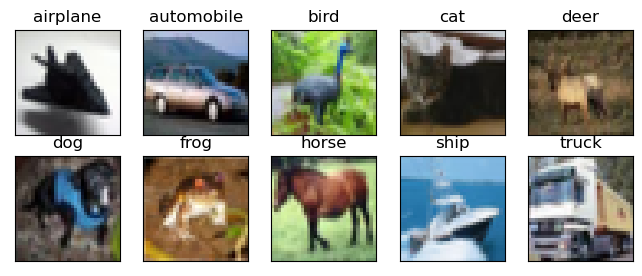

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [4]:
type(cifar10).__mro__ # 多重継承クラスの確認 -> ベースクラスにDatasetクラスが使用されている

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [5]:
len(cifar10)

50000

PytorchのDatasetクラスは, `__len__`と`__getitem__`メソッドを実装してデータへのアクセスクラスとする.   必ずしもDatasetクラスに実データがある必要はない.

In [6]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

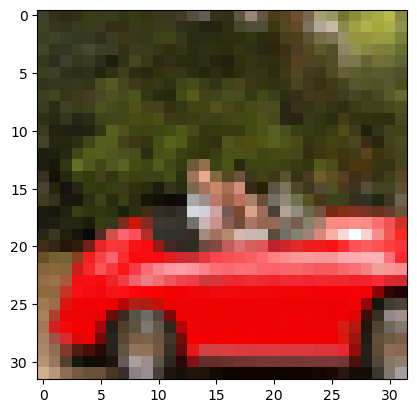

In [7]:
plt.imshow(img)
plt.show()

### データセットの変換
torchvision.transformは組合せ可能な関数オブジェクトを提供する

In [8]:
from torchvision import transforms
print(dir(transforms))


['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'ElasticTransform', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'TenCrop', 'ToPILImage', 'ToTensor', 'TrivialAugmentWide', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_pil_constants', '_presets', 'autoaugment', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


In [9]:
print(len(dir(transforms)))

57


PIL -> Tensor

In [10]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [11]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [12]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [13]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [14]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

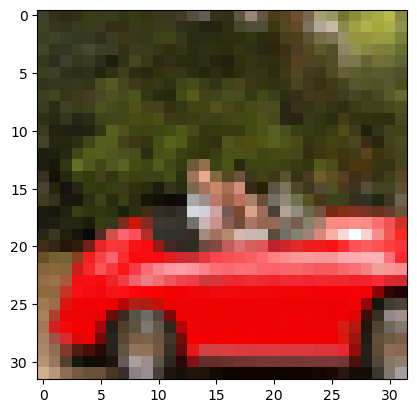

In [15]:
plt.imshow(img_t.permute(1, 2, 0))  # (C,H,W) -> (H,W,C)
plt.show()

### データの正規化(標準化)

In [16]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [17]:
imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [19]:
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [20]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [22]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

In [23]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


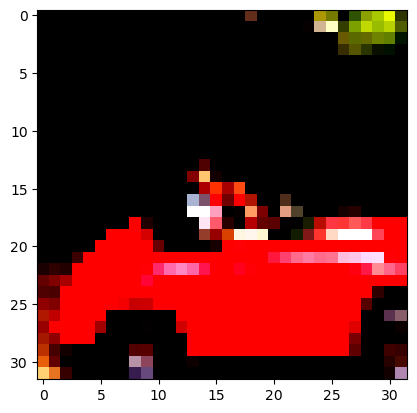

In [24]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))
plt.show()

### 画像分類モデルの構築
CIFAR10から`鳥`と`飛行機`のデータを抜き出して分類モデルを作成する

In [37]:
label_map = {0: 0, 2: 1} # 0: 飛行機, 2: 鳥
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

In [38]:
cifar2

[(tensor([[[ 0.6139, -0.3228,  ..., -0.2752, -0.5451],
           [ 0.6615, -0.1482,  ..., -0.3228, -0.5768],
           ...,
           [ 0.5980,  0.4393,  ..., -0.4340,  0.0265],
           [ 0.9156,  0.8044,  ..., -0.5451, -0.0529]],
  
          [[ 1.3369,  0.2740,  ...,  0.3867,  0.0968],
           [ 1.4497,  0.5961,  ...,  0.3062,  0.0646],
           ...,
           [ 0.5478,  0.6605,  ...,  0.4028,  0.8860],
           [ 0.4834,  0.9504,  ...,  0.1613,  0.7572]],
  
          [[-0.4487, -0.7935,  ..., -0.6736, -0.8535],
           [-0.4487, -0.9734,  ..., -0.6286, -0.8535],
           ...,
           [-0.4337, -0.4787,  ..., -1.3032, -0.9884],
           [-0.1789,  0.0310,  ..., -1.3182, -1.0484]]]),
  1),
 (tensor([[[-1.7200, -1.7200,  ..., -1.6406, -1.6882],
           [-1.7041, -1.7041,  ..., -1.6247, -1.6406],
           ...,
           [ 1.4871,  1.5348,  ..., -1.4501, -1.4659],
           [ 1.3442,  1.5189,  ..., -1.4501, -1.4818]],
  
          [[-1.9324, -1.9324,  ...,

In [39]:
type(cifar2)

list

全結合モデル

In [40]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072, # in
        512,  # out
    ),
    nn.Tanh(),
    nn.Linear(
        512,   # in
        n_out, # out
    )
)

model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
)

In [41]:
# softmaxでスコアをクラス確率に変換
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [42]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [43]:
softmax(x).sum()

tensor(1.)

torch.nn.softmaxでは, softmax関数が適用される次元を指定する必要がある

In [44]:
softmax = nn.Softmax(dim=1) # [C,L] Lに適用
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [45]:
model = nn.Sequential(
    nn.Linear(
        3072, # in
        512,  # out
    ),
    nn.Tanh(),
    nn.Linear(
        512,   # in
        n_out, # out
    ),
    nn.Softmax(dim=1) # softmaxを追加
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


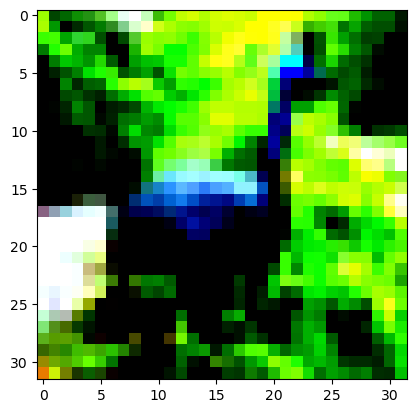

In [46]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

ミニバッチの次元(N)を追加 (N,C,H,W)

In [47]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.size()

torch.Size([1, 3072])

In [49]:
# モデル入力して確率を見てみる
out = model(img_batch)
out # ランダム(どっちつかず)

tensor([[0.5182, 0.4818]], grad_fn=<SoftmaxBackward0>)

torch.maxは次元が与えられるとその次元に沿った最大の要素と値が発生するインデックスを返す

In [50]:
_, index = torch.max(out, dim=1)
index

tensor([0])

#### 分類問題で用いる損失関数
+ 分類問題における損失関数への入力は, データxが与えらえた時のNNモデルの尤度`P(x|Θ)`となる.  
+ 損失関数に求められる機能は, 尤度が低いときに損失が大きくなること.
+ ピッタリな損失関数は, 負の対数尤度`NLL(Negative Log Likelihood) = -sum(log(out_i[c_i]))`

`nn.NLLLoss`クラスがあるが, このモジュールは確率ではなく対数確率のテンソルを入力として受け取る.  
そして, バッチを指定してモデルのNLLを計算する.

In [51]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

MSE損失の場合

In [57]:
# 平均二乗誤差
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [53]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

NLL損失の場合

In [55]:
# 尤度
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [58]:
# 負の対数尤度
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

出力調整したout

In [59]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [60]:
# 元のoutとの変換量
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [61]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

工夫せずに, 尤度ゼロの対数尤度を計算するとマイナス∞d内に発散してしまう

In [62]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [63]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [65]:
log_softmax(x) # 一番高いスコアの負の値でクリップされる

tensor([[-104.,    0.]])

In [66]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [67]:
# nn.Softmax -> nn.LogSoftmax
model = nn.Sequential(
    nn.Linear(
        3072, # in
        512,  # out
    ),
    nn.Tanh(),
    nn.Linear(
        512,   # in
        n_out, # out
    ),
    nn.LogSoftmax(dim=1) # logsoftmaxに変更
)

In [68]:
# 損失関数
loss = nn.NLLLoss()

In [69]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.7383, grad_fn=<NllLossBackward0>)

#### 分類器の訓練

In [77]:
# 初期設定
# GPUが使えるか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス: ", device)

# ネットワークがある程度固定であれば、高速化される
torch.backends.cudnn.benchmark = True

使用デバイス:  cuda:0


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(
        3072, # in
        512,  # out
    ),
    nn.Tanh(),
    nn.Linear(
        512,   # in
        n_out, # out
    ),
    nn.LogSoftmax(dim=1) # logsoftmaxに変更
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 10

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        # modelとlossをGPUに転送
        out = out.to('cuda:0')
        loss = loss.to('cuda:0')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 7.157055
Epoch: 1, Loss: 10.651847
Epoch: 2, Loss: 4.800366
Epoch: 3, Loss: 3.283083
Epoch: 4, Loss: 8.735953
Epoch: 5, Loss: 16.083164
Epoch: 6, Loss: 4.442674
Epoch: 7, Loss: 13.460336
Epoch: 8, Loss: 11.415195
Epoch: 9, Loss: 6.926763


### torch.utils.data.DataLoader
+ Dataset(`__len__, __getitem__`)からシャッフルしたミニバッチをサンプリングする
+ Datasetオブジェクト, バッチサイズ, 各エポック開始時のシャッフルフラグの3つが最低限必要

学習なし状態(train)

In [81]:
train_loader = torch.utils.data.DataLoader(dataset=cifar2,
                                           batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy of train: %f" % (correct / total))

Accuracy of train: 0.693500


学習なし状態(val)

In [83]:
val_loader = torch.utils.data.DataLoader(dataset=cifar2_val,
                                         batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy of val: %f" % (correct / total))

Accuracy of val: 0.633000


In [84]:
# モデルに複雑さを追加
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

`nn.LogSoftmax`と`nn.NLLLoss`の組合せは, `nn.CorssEntropyLoss`と同等.
+ nn.NLLLossは内部でクロスエントロピー誤差を計算する.
+ nn.NLLLossは, すべての量をターゲットに配置するディラック分布と対数尤度によって与えられる予測分布との間のクロスエントロピーを計算する.
+ クロスエントロピーはディラックのデルタ関数を用いた経験分布と予測分布との間のKLダイバージェンスから計算できる.
+ nn.NLLLossには, 対数尤度を入力する.
+ nn.CrossEntropyLossには, スコア(ロジット)を入力する.

In [85]:
# nn.logSoftmaxをnn.NLLLossとまとめてnn.CrossEntropyLoss損失関数としてモデルから外に出す
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

+ `nn.CrossEntropyLoss`を使うとすべての処理を行うことができて便利だが, モデル出力を確率として取り出すことができない.  
+ モデルの最終レイヤに`nn.LogSoftmax`を入れて, 損失関数として`nn.NLLLoss`に分けるほうが良い.
+ モデルの尤度(出力予測確率)は, `nn.LogSoftmax`に`nn.exp`を適用して取得する.


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        # outputsとlossをGPUに転送したうえで, バックプロパゲーションを行う
        outputs = outputs.to('cuda:0')
        loss = loss.to('cuda:0')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.375794
Epoch: 1, Loss: 0.569167
Epoch: 2, Loss: 0.597193
Epoch: 3, Loss: 0.260052
Epoch: 4, Loss: 0.544769
Epoch: 5, Loss: 0.413991
Epoch: 6, Loss: 0.474851
Epoch: 7, Loss: 0.460120
Epoch: 8, Loss: 0.506543
Epoch: 9, Loss: 0.492887
Epoch: 10, Loss: 0.245056
Epoch: 11, Loss: 0.463954
Epoch: 12, Loss: 0.467277
Epoch: 13, Loss: 0.349338
Epoch: 14, Loss: 0.409966
Epoch: 15, Loss: 0.197697
Epoch: 16, Loss: 0.310041
Epoch: 17, Loss: 0.170276
Epoch: 18, Loss: 0.805646
Epoch: 19, Loss: 0.460419
Epoch: 20, Loss: 0.240666
Epoch: 21, Loss: 0.501751
Epoch: 22, Loss: 0.395342
Epoch: 23, Loss: 0.267305
Epoch: 24, Loss: 0.608949
Epoch: 25, Loss: 0.229907
Epoch: 26, Loss: 0.137781
Epoch: 27, Loss: 0.213590
Epoch: 28, Loss: 0.342750
Epoch: 29, Loss: 0.431180
Epoch: 30, Loss: 0.334566
Epoch: 31, Loss: 0.227614
Epoch: 32, Loss: 0.239357
Epoch: 33, Loss: 0.140838
Epoch: 34, Loss: 0.239383
Epoch: 35, Loss: 0.043921
Epoch: 36, Loss: 0.528447
Epoch: 37, Loss: 0.519983
Epoch: 38, Loss: 0.063

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss() #nn.CrossEntropyLoss()

n_epochs = 10
n_iteration = 0

for epoch in range(n_epochs):
    for iter, (imgs, labels) in enumerate(train_loader):
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        # outputsとlossをGPUに転送したうえで, バックプロパゲーションを行う
        outputs = outputs.to('cuda:0')
        loss = loss.to('cuda:0')

        predictions = torch.exp(outputs.clone().detach()) # 尤度を取り出す

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        n_iteration += 1
        print(f"Iteration: {n_iteration}, Prediction with batch=64: \n{predictions} ")

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Iteration: 1, Prediction with batch=64: 
tensor([[0.5268, 0.4732],
        [0.4989, 0.5011],
        [0.4768, 0.5232],
        [0.5092, 0.4908],
        [0.5321, 0.4679],
        [0.5443, 0.4557],
        [0.5177, 0.4823],
        [0.5230, 0.4770],
        [0.4735, 0.5265],
        [0.5146, 0.4854],
        [0.5007, 0.4993],
        [0.4708, 0.5292],
        [0.5150, 0.4850],
        [0.5378, 0.4622],
        [0.5219, 0.4781],
        [0.5594, 0.4406],
        [0.5411, 0.4589],
        [0.4936, 0.5064],
        [0.5056, 0.4944],
        [0.5251, 0.4749],
        [0.4963, 0.5037],
        [0.5433, 0.4567],
        [0.4841, 0.5159],
        [0.5353, 0.4647],
        [0.4950, 0.5050],
        [0.5420, 0.4580],
        [0.5000, 0.5000],
        [0.5298, 0.4702],
        [0.5157, 0.4843],
        [0.4779, 0.5221],
        [0.5584, 0.4416],
        [0.4888, 0.5112],
        [0.5081, 0.4919],
        [0.5063, 0.4937],
        [0.4787, 0.5213],
        [0.5137, 0.4863],
        [0.4630, 0.5370